In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pickle
import io

from rdkit import Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem import MolStandardize
from tqdm import tqdm
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import SaltRemover, MolStandardize
from contextlib import redirect_stderr
from imblearn.over_sampling import ADASYN, SMOTE

In [11]:
sys.path.append('../')

In [73]:
from scripts.utils import (
    remove_ambiguous_smiles, form_data,
    balance_with_interpolate, featurize_ecfp4, compute_metrics, balance_classes,
    load_embeddings_from_hdf5, train_test_split, embeddings_dict_to_df, expand_embeddings, embeddings_dict_to_df
)

In [13]:
df = pd.read_csv('../data/tox_dataset.csv')

In [120]:
def filter_and_log(df: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """
    Process a DataFrame of SMILES strings, stripping salts and canonicalizing tautomers.
    Returns a new DataFrame with valid molecules (including the original index) and a dict of per-row logs.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'SMILES' and 'toxicity'.

    Returns
    -------
    processed_df : pd.DataFrame
        Columns:
          - 'orig_idx': original DataFrame index
          - 'SMILES': cleaned canonical SMILES
          - 'toxicity': original labels
          - 'mol': RDKit Mol objects
    logs : dict[int, str]
        Mapping from original DataFrame index to captured stderr log.
    """
    remover = SaltRemover.SaltRemover()
    canonicalizer = MolStandardize.rdMolStandardize.TautomerEnumerator()

    log_kekulize = "Can't kekulize mol."
    log_remove_hydrogen = "not removing hydrogen atom without neighbors"
    log_tautomer_enumeration_stopped = "Tautomer enumeration stopped"

    clean_data = {
        'orig_idx': [],
        'SMILES': [],
        'toxicity': [],
        'mol': []
    }
    logs = {}

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Filtering molecules"):
        smi = row['SMILES']
        label = row['toxicity']

        stderr_buffer = io.StringIO()
        with redirect_stderr(stderr_buffer):
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                stderr_buffer.write(f"[{idx}] Invalid SMILES: {smi}\n")
            else:
                mol = remover.StripMol(mol, dontRemoveEverything=True)
                mol = canonicalizer.Canonicalize(mol)
                smi_clean = Chem.MolToSmiles(mol, canonical=True)

        log_text = stderr_buffer.getvalue()
        stderr_buffer.close()

        # Save log if any
        if log_text:
            logs[idx] = log_text

        # Only keep molecules that parsed correctly and have no kekulization errors
        if mol is not None and log_kekulize not in log_text and log_remove_hydrogen not in log_text and log_tautomer_enumeration_stopped not in log_text:
            clean_data['orig_idx'].append(idx)
            clean_data['SMILES'].append(smi_clean)
            clean_data['toxicity'].append(label)
            clean_data['mol'].append(mol)

    processed_df = pd.DataFrame(clean_data)
    processed_df.set_index('orig_idx', inplace=True)
    delta = len(processed_df) / len(df) * 100
    print(f"Delta: {delta:.2f}%")
    return processed_df, logs

In [ ]:
processed_df, logs = filter_and_log(df)

Filtering molecules:   0%|          | 0/8485 [00:00<?, ?it/s]

Filtering molecules:  50%|█████     | 4283/8485 [01:08<01:33, 44.85it/s] 

In [21]:
processed_df.to_csv('../data/processed_df.csv', index=True)

In [22]:
with open('../data/logs.pkl', 'wb') as f:
    pickle.dump(logs, f)

In [19]:
with open('../data/logs.pkl', 'rb') as f:
    logs = pickle.load(f)

In [5]:
processed_df = pd.read_csv('../data/processed_df.csv')

In [20]:
for idx in processed_df.index:
    if idx in logs:
        print(logs[idx])

[15:17:48] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:17:57] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:18:13] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:18:21] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:18:38] Tautomer enumeration stopped at 4759 tautomers: max transforms reached

[15:18:50] Tautomer enumeration stopped at 4828 tautomers: max transforms reached

[15:18:59] Tautomer enumeration stopped at 2867 tautomers: max transforms reached

[15:19:11] Tautomer enumeration stopped at 1771 tautomers: max transforms reached

[15:19:20] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:19:35] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:19:41] Tautomer enumeration stopped at 841 tautomers: max transforms reached

[15:19:48] Tautomer enumeration stopped at 5000 tautomers: max tautomers reached

[15:20:11] T

In [23]:
processed_df = processed_df.reset_index(drop=True)

In [24]:
processed_df.isna().sum()

SMILES         0
toxicity    1633
mol            0
dtype: int64

In [92]:
processed_df['SMILES'].duplicated().sum()

679

In [93]:
df_copied = processed_df.copy()

In [94]:
df_copied = remove_ambiguous_smiles(df_copied)

In [97]:
df_copied.sample(n=1000)

,SMILES,toxicity,mol
5316,S=c1[nH]c2ccccc2[nH]1,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744f14d0>
4930,CN1C(=O)CC[C@H]1c1cccnc1,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744de2d0>
910,CCCCOC(=O)C(C)OC(=O)CCC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa741ef840>
4336,CC(=O)Nc1c(I)c(NC(C)=O)c(I)c(C(=O)O)c1I,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744b4eb0>
4720,CC(C)C(C(=O)O[C@H](C#N)c1cccc(Oc2ccccc2)c1)c1c...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744caa40>
...,...,...,...
3520,CCCC(=O)OCCC(C)C,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa74487a70>
3116,CN1C(C)(C)CC(O)CC1(C)C,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa7446e420>
2293,O=C1c2ccccc2C(=O)N1CO,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa7443e730>
1092,O=P(OCC(Br)CBr)(OCC(Br)CBr)OCC(Br)CBr,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa741f5ee0>


### Train test split

In [98]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaf = MurckoScaffold.MakeScaffoldGeneric(
        MurckoScaffold.GetScaffoldForMol(mol)
    )
    return Chem.MolToSmiles(scaf)


* Murcko Scaffold — это каркас молекулы, состоящий из:
* кольцевых структур (rings)
* линкеров между кольцами (linkers)
* удаляются все боковые цепи (side chains)

In [99]:
df_copied = df_copied.sample(frac=1, random_state=42)

In [101]:
df_copied

,SMILES,toxicity,mol
6275,CN(C)c1ccc2nc3ccc(N(C)C)cc3[s+]c2c1,NaN,<rdkit.Chem.rdchem.Mol object at 0x7faa7452ece0>
1904,O=C(O)c1cc(Cl)cc([N+](=O)[O-])c1Cl,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa74225ee0>
6099,O=C(C=Cc1ccccc1)OCc1ccccc1,1.0,<rdkit.Chem.rdchem.Mol object at 0x7faa74525a80>
4131,CCOC(=O)C1=C(COCCN)N=C(C)C(C(=O)OC)C1c1ccccc1C...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744ae110>
3205,[Zn+2],0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa7446eab0>
...,...,...,...
5315,CCCCCCCCCCCCCCOS(=O)(=O)[O-],0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744f1700>
5481,CC(NNC(=O)c1ccccc1)c1ccccc1,1.0,<rdkit.Chem.rdchem.Mol object at 0x7faa744fec70>
929,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],0.0,<rdkit.Chem.rdchem.Mol object at 0x7faa741efd10>
7704,CC(O)COC(C)(C)C,NaN,<rdkit.Chem.rdchem.Mol object at 0x7faa743949e0>


In [102]:
smi = '[Zn+2]'

In [103]:
mol = Chem.MolFromSmiles(smi)

In [105]:
def is_organic(mol):
    # Проверим, содержит ли молекула углерод
    return any(atom.GetAtomicNum() == 6 for atom in mol.GetAtoms())

def is_valid_organic_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return False
    return mol.GetNumAtoms() > 1 and is_organic(mol)

In [115]:
organic_smiles = df_copied['SMILES'].apply(is_valid_organic_smiles)

organic_smiles.sum() / len(organic_smiles)

0.9905170174071187

In [118]:
df_copied[~organic_smiles].sample()

,SMILES,toxicity,mol
7903,[O-][Cl+3]([O-])([O-])[O-],1.0,<rdkit.Chem.rdchem.Mol object at 0x7faa7439c0b0>


In [119]:
mol = Chem.MolFromSmiles('[O-][Cl+3]([O-])([O-])[O-]')
Chem.MolToSmiles(mol)

'[O-][Cl+3]([O-])([O-])[O-]'

In [90]:
df_copied['scaffold'] = df_copied['SMILES'].apply(scaffold)
df_copied.to_csv('../data/df_copied.csv', index=False)

AttributeError: 'CC1CCCCCCCCCCCCCCC1' is not a valid function for 'Series' object

In [30]:
df_cleaned = df_copied.dropna().reset_index(drop=True)

In [31]:
df_cleaned['toxicity'].value_counts()

toxicity
0.0    5288
1.0     784
Name: count, dtype: int64

In [32]:
5289 / 784

6.746173469387755

In [40]:
scaffold_counts = df_cleaned['scaffold'].value_counts().sort_values(ascending=False)
scaffold_counts

scaffold
                                                               1532
C1CCCCC1                                                       1509
C1CCC(CC2CCCCC2)CC1                                             162
C1CCCC1                                                         152
C1CCC2CCCC2C1                                                   110
                                                               ... 
CC(CC1CCCC1)CC1CCC2CCC(CC3CCC(C(C)CC(C)(C)C4CCCCC4)CC3)C2C1       1
C1CCCCC1.CC1CC(C)C2CCCC2C1                                        1
CC1CCC(C2CC2)C2CC(C3CCC(C)C3)CCC12                                1
C1CCCC(C(C2CCCCC2)C2CCCCC2)CC1                                    1
CC(CC1C(C)C2CCCC21)C1CCCC1C1CCCCC1                                1
Name: count, Length: 1018, dtype: int64

In [41]:
scaffold_label_counts = df_cleaned.groupby('scaffold')['toxicity'].nunique()
scaffold_label_counts.value_counts()

toxicity
1    874
2    144
Name: count, dtype: int64

### Descriptors generation

In [87]:
X_ecfp = np.vstack([featurize_ecfp4(m) for m in df_cleaned['mol']])
y = df_cleaned['toxicity'].values
groups = df_cleaned['scaffold'].values

In [43]:
train_idx_random, test_idx_random = train_test_split(X_ecfp, y, n_splits=6)

In [44]:
len(test_idx_random) / len(train_idx_random)

0.2

In [50]:
df_train_random_split, df_test_random_split = form_data(df_cleaned, train_idx_random, test_idx_random)

In [51]:
df_train_random_split['toxicity'].value_counts()

toxicity
0.0    4406
1.0     654
Name: count, dtype: int64

In [52]:
scaffold_classes = {}

grouped = df_test_random_split.groupby('scaffold')['toxicity']

for scaffold, values in grouped:
    unique_vals = set(values)
    if unique_vals == {1}:
        scaffold_classes[scaffold] = '1'
    elif unique_vals == {0}:
        scaffold_classes[scaffold] = '0'
    else:
        scaffold_classes[scaffold] = '0_1'

In [53]:
train_scaffolds = df_train_random_split['scaffold'].unique()
test_scaffolds = df_test_random_split['scaffold'].unique()

intersected_scaffolds = np.intersect1d(train_scaffolds, test_scaffolds)
unique_test_scaffolds = np.setdiff1d(test_scaffolds, train_scaffolds)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_random_split['mol']])
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [56]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [57]:
compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.627906976744186,
 'recall': 0.2076923076923077,
 'sensitivity': 0.981859410430839,
 'f1': 0.31213872832369943,
 'roc_auc': 0.7194444444444444}

In [58]:
df_train_oversampled = balance_classes(df_train_random_split, target_col='toxicity', method='oversample')

model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_oversampled['mol']])
y_train = df_train_oversampled['toxicity'].values
model.fit(X_train, y_train)

X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.4537037037037037,
 'recall': 0.3769230769230769,
 'sensitivity': 0.9331065759637188,
 'f1': 0.4117647058823529,
 'roc_auc': 0.7156070120355834}

In [59]:
df_train_undersampled = balance_classes(df_train, target_col='toxicity', method='undersample')

model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_undersampled['mol']])
y_train = df_train_undersampled['toxicity'].values
model.fit(X_train, y_train)


X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.24188790560471976,
 'recall': 0.6307692307692307,
 'sensitivity': 0.7086167800453514,
 'f1': 0.34968017057569295,
 'roc_auc': 0.7215724751439037}

In [60]:
X_train = np.vstack([featurize_ecfp4(m) for m in df_train_undersampled['mol']])
df_trained_featurized = pd.DataFrame(X_train)
df_trained_featurized['toxicity'] = df_train_undersampled['toxicity'].values
df_trained_featurized_smote = balance_with_interpolate(df_trained_featurized, class_balancer=SMOTE)

model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = df_trained_featurized_smote.drop(columns=['toxicity']).values
y_train = df_trained_featurized_smote['toxicity'].values
model.fit(X_train, y_train)

X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.24188790560471976,
 'recall': 0.6307692307692307,
 'sensitivity': 0.7086167800453514,
 'f1': 0.34968017057569295,
 'roc_auc': 0.7215724751439037}

In [62]:
df_trained_featurized_adasyn = balance_with_interpolate(df_trained_featurized, class_balancer=ADASYN)

model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = df_trained_featurized_adasyn.drop(columns=['toxicity']).values
y_train = df_trained_featurized_adasyn['toxicity'].values
model.fit(X_train, y_train)


X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.24188790560471976,
 'recall': 0.6307692307692307,
 'sensitivity': 0.7086167800453514,
 'f1': 0.34968017057569295,
 'roc_auc': 0.7215724751439037}

#### MACCSkeys

In [65]:
from rdkit.Chem import MACCSkeys

model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = np.vstack([np.array(MACCSkeys.GenMACCSKeys(m)) for m in df_train_random_split['mol']])
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)

X_test = np.vstack([np.array(MACCSkeys.GenMACCSKeys(m)) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.6,
 'recall': 0.25384615384615383,
 'sensitivity': 0.9750566893424036,
 'f1': 0.3567567567567568,
 'roc_auc': 0.7224795046223617}

In [383]:
scaffold_metrics = []

df_test_reindexed = df_test.reset_index(drop=True)

for scaffold in df_test['scaffold'].unique():
    idx = df_test_reindexed[df_test_reindexed['scaffold'] == scaffold].index
    y_test_sample = y_test[idx]
    y_pred_sample = y_pred[idx]
    y_proba_sample = y_proba[idx]

    metrics_sample = compute_metrics(y_test_sample, y_pred_sample, y_proba_sample)
    counts_class = scaffold_classes[scaffold]
    scaffold_metrics.append({'scaffold': scaffold, 'counts_class': counts_class, **metrics_sample})

scaffold_metrics_df = pd.DataFrame(scaffold_metrics)

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [45]:
# scaffold_metrics_df

### to do посчитать агрегированную метрику

In [385]:
intersected_scaffold_metrics = scaffold_metrics_df[scaffold_metrics_df['scaffold'].isin(intersected_scaffolds)]
intersected_scaffold_metrics

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc
0,CC1CCC(C2CCCCC2)C1,0,0.000000,0.000000,1.000000,0.000000,NaN
1,,0_1,0.000000,0.000000,0.991228,0.000000,0.647962
2,C1CCCCC1,0_1,0.222222,0.105263,0.969697,0.142857,0.659148
4,CC(CCC1CCCCC1)CC1CCCCC1,0,0.000000,0.000000,1.000000,0.000000,NaN
5,CC1(C)CCCC2CCCC21,0,0.000000,0.000000,1.000000,0.000000,NaN
...,...,...,...,...,...,...,...
299,CC1CCCC(CCC2CCCCC2)C1,1,0.000000,0.000000,0.000000,0.000000,NaN
300,CC(CC1CCCCC1)(CC1CCCCC1)CC1CCCCC1,1,0.000000,0.000000,0.000000,0.000000,NaN
302,C1CCC(C2CC3CCCCC3C2)CC1,1,0.000000,0.000000,0.000000,0.000000,NaN
303,CC1(C)CCCC2CCCCC21,1,0.000000,0.000000,0.000000,0.000000,NaN


In [386]:
unique_test_scaffolds_metrics = scaffold_metrics_df[scaffold_metrics_df['scaffold'].isin(unique_test_scaffolds)]
unique_test_scaffolds_metrics

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc
3,CC(CCC1CCCCC1)CCC1CCCC(CC2CCCCC2)C1,0,0.0,0.0,1.0,0.0,NaN
6,CC(CCC1CCCC1)C1C(C)CC2CC3CC4CCCCC4C(C)C3C(C)C2C1C,0,0.0,0.0,1.0,0.0,NaN
8,C1CCC(CC2CCC3CCCC3C2)C1,0,0.0,0.0,1.0,0.0,NaN
11,CC1CC(CCC2CCCCC2)CC(C)C1CC1CCCCC1,0,0.0,0.0,1.0,0.0,NaN
12,CC1CC23CCC4C(C(C)CC5CCCCC5)CCCC4C2CC(CC2CCCC(C...,0,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...
305,CC1CCC2C(CCC3C4CCC(C)CC4CCC23)C1,1,1.0,1.0,0.0,1.0,NaN
306,CC1CCCCCCCCCCCC2CCCCC12,1,0.0,0.0,0.0,0.0,NaN
308,C1CCC(C2CC3CCCCC3CC3CCCCC32)CC1.C1CCC(C2CC3CCC...,1,0.0,0.0,0.0,0.0,NaN
309,C1CCC(C2CCC3C2CCC2C4CCCCC4CCC23)CC1,1,1.0,1.0,0.0,1.0,NaN


In [46]:
train_idx_grouped, test_idx_grouped = train_test_split(X_ecfp, y, groups=groups, n_splits=3)

In [47]:
df_train_grouped, df_test_grouped = form_data(df_cleaned, train_idx_grouped, test_idx_grouped)

df_train_grouped.shape, df_test_grouped.shape

((5522, 4), (550, 4))

In [389]:
df_train_grouped['toxicity'].value_counts(), df_test_grouped['toxicity'].value_counts()

(toxicity
 0.0    4825
 1.0     697
 Name: count, dtype: int64,
 toxicity
 0.0    463
 1.0     87
 Name: count, dtype: int64)

In [390]:
scaffold_classes_grouped = {}

grouped = df_test_grouped.groupby('scaffold')['toxicity']

for scaffold, values in grouped:
    unique_vals = set(values)
    if unique_vals == {1}:
        scaffold_classes_grouped[scaffold] = '1'
    elif unique_vals == {0}:
        scaffold_classes_grouped[scaffold] = '0'
    else:
        scaffold_classes_grouped[scaffold] = '0_1'

In [392]:
model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_grouped['mol']])
y_train = df_train_grouped['toxicity'].values
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [393]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_grouped['mol']])
y_test = df_test_grouped['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [394]:
compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.6,
 'recall': 0.06896551724137931,
 'sensitivity': 0.9913606911447084,
 'f1': 0.12371134020618557,
 'roc_auc': 0.6906481964201485}

In [395]:
scaffold_metrics = []

df_test_reindexed = df_test_grouped.reset_index(drop=True)

for scaffold in df_test_grouped['scaffold'].unique():
    idx = df_test_reindexed[df_test_reindexed['scaffold'] == scaffold].index
    y_test_sample = y_test[idx]
    y_pred_sample = y_pred[idx]
    y_proba_sample = y_proba[idx]
    counts_class = scaffold_classes_grouped[scaffold]

    metrics_sample = compute_metrics(y_test_sample, y_pred_sample, y_proba_sample)
    scaffold_metrics.append({'scaffold': scaffold, 'counts_class': counts_class, **metrics_sample})

scaffold_metrics_df = pd.DataFrame(scaffold_metrics)

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [396]:
scaffold_metrics_df

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc
0,CC1CC(C)C2C(CCC2CC2CCCC2)C1,0,0.0,0.0,1.0,0.0,NaN
1,CC1CCCC1,0_1,0.0,0.0,1.0,0.0,0.663399
2,CC(CCC1CCCCC1)CC1CCCCC1,0,0.0,0.0,1.0,0.0,NaN
3,CC(CC1CCCC1)CC1C(C)C2CC(CCC3CCCC3)CCC12,0,0.0,0.0,1.0,0.0,NaN
4,CC1CCC2C(CCC3C2CCC2C4CCCC4CC23)C1,0_1,0.0,0.0,1.0,0.0,0.500000
...,...,...,...,...,...,...,...
227,CC1CCCC1C1CCC(C2CCCCC2)CC1,1,0.0,0.0,0.0,0.0,NaN
228,CC(CCC1CCCC2CCCCC21)CC1CCCCC1C(C)C1CCC2(CCCC2)CC1,1,0.0,0.0,0.0,0.0,NaN
229,CC1C2CC3CCC(CC4CCC(C4)CC4CCC(C4)CC(C2)C1C)C3,1,0.0,0.0,0.0,0.0,NaN
230,CC1CCC2C(CCC3C4CCC(C)C4CCC23)C1C,1,1.0,1.0,0.0,1.0,NaN


In [401]:
scaffold_metrics = []

df_test_reindexed = df_test.reset_index(drop=True)

for scaffold in df_test['scaffold'].unique():
    idx = df_test_reindexed[df_test_reindexed['scaffold'] == scaffold].index
    y_test_sample = y_test[idx]
    y_pred_sample = y_pred[idx]
    y_proba_sample = y_proba[idx]
    counts_class = scaffold_classes[scaffold]

    metrics_sample = compute_metrics(y_test_sample, y_pred_sample, y_proba_sample)
    scaffold_metrics.append({'scaffold': scaffold, 'counts_class': counts_class, **metrics_sample})

scaffold_metrics_df = pd.DataFrame(scaffold_metrics)

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [402]:
scaffold_metrics_df

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc
0,CC1CCC(C2CCCCC2)C1,0,0.000,0.000000,1.000000,0.000000,NaN
1,,0_1,0.000,0.000000,0.991228,0.000000,0.626290
2,C1CCCCC1,0_1,0.375,0.157895,0.978355,0.222222,0.591593
3,CC(CCC1CCCCC1)CCC1CCCC(CC2CCCCC2)C1,0,0.000,0.000000,1.000000,0.000000,NaN
4,CC(CCC1CCCCC1)CC1CCCCC1,0,0.000,0.000000,1.000000,0.000000,NaN
...,...,...,...,...,...,...,...
306,CC1CCCCCCCCCCCC2CCCCC12,1,1.000,1.000000,0.000000,1.000000,NaN
307,CC1C2CCCCC2CCC1C1CCCCC1,1,1.000,1.000000,0.000000,1.000000,NaN
308,C1CCC(C2CC3CCCCC3CC3CCCCC32)CC1.C1CCC(C2CC3CCC...,1,0.000,0.000000,0.000000,0.000000,NaN
309,C1CCC(C2CCC3C2CCC2C4CCCCC4CCC23)CC1,1,0.000,0.000000,0.000000,0.000000,NaN


### Chem Bert embeddings

In [71]:
embeddings = load_embeddings_from_hdf5('../data/chemberta_pooler_embeddings.h5')
mapper_df = pd.read_csv('../data/mapper_df.csv')

In [72]:
df_train_with_ids = df_train_random_split.merge(mapper_df, on='SMILES')
df_test_with_ids = df_test_random_split.merge(mapper_df, on='SMILES')

In [76]:
embeddings_df = embeddings_dict_to_df(embeddings)
embeddings_df = expand_embeddings(embeddings_df)

In [77]:
df_train_embedded = df_train_with_ids[['toxicity', 'SMILES ID']].merge(embeddings_df, on='SMILES ID').drop(columns=['SMILES ID'])
df_test_embedded = df_test_with_ids[['toxicity', 'SMILES ID']].merge(embeddings_df, on='SMILES ID').drop(columns=['SMILES ID'])

In [79]:
model = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)

X_train = df_train_embedded.drop(columns=['toxicity']).values
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [81]:
df_train_embedded

,toxicity,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,...,Component_374,Component_375,Component_376,Component_377,Component_378,Component_379,Component_380,Component_381,Component_382,Component_383
0,0.0,0.202076,0.052563,0.031796,0.248058,-0.115120,-0.111798,-0.506317,0.264881,0.021558,...,-0.332821,-0.162668,-0.014511,-0.290116,0.230979,-0.042493,0.949712,-0.034459,0.293706,-0.136284
1,0.0,0.184704,-0.092396,-0.388940,-0.392391,0.793621,-0.493432,-0.241305,0.393220,0.824331,...,-0.233824,0.179641,0.245266,0.059855,0.460581,-0.481007,0.492252,-0.272861,0.643227,0.145924
2,0.0,0.178078,-0.208879,-0.406502,0.556888,-0.062192,0.435572,-0.220009,0.864810,0.036919,...,-0.585905,-0.289602,-0.099216,-0.140524,0.202045,-0.113704,0.295533,0.700562,0.673887,-0.006875
3,0.0,0.660996,-0.049336,-0.257751,0.326913,0.543962,0.236539,-0.564892,0.249691,0.092994,...,-0.073033,0.122037,0.492211,-0.195237,-0.077435,-0.135968,0.259445,-0.187424,0.387085,0.275129
4,0.0,-0.380499,0.225684,-0.074954,-0.008929,0.332990,-0.083321,-0.130053,0.228785,0.380198,...,-0.346110,-0.124009,0.199103,0.442374,0.387830,-0.269599,0.541572,-0.180472,0.081874,0.181061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,1.0,0.301317,0.143353,-0.208889,0.245702,0.285713,0.352037,-0.662130,0.327244,0.515061,...,-0.497724,0.229768,-0.015910,0.185736,0.370843,-0.244513,1.071457,0.308262,-0.065943,-0.200703
5056,1.0,0.352321,-0.017794,-0.223096,0.352869,0.350702,0.289245,-0.723225,0.246321,0.197072,...,-0.647800,0.273885,0.032091,-0.039073,0.342290,-0.072394,0.998102,0.240793,-0.098424,-0.044119
5057,1.0,0.148414,-0.213897,-0.078754,0.566632,0.234156,0.127534,-0.652295,0.111551,-0.016759,...,-0.553343,0.220386,-0.040482,-0.162711,0.258743,0.084423,1.063408,0.211268,-0.144802,-0.093112
5058,1.0,0.079731,-0.131583,-0.328143,0.360735,0.109753,0.472419,-0.641096,0.513289,0.530629,...,-0.373352,-0.009305,-0.042294,-0.004480,0.492852,-0.468021,0.695659,0.281570,0.367116,-0.461823


In [80]:
X_test = df_test_embedded.drop(columns=['toxicity']).values
y_test = df_test_embedded['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.7142857142857143,
 'recall': 0.23076923076923078,
 'sensitivity': 0.9863945578231292,
 'f1': 0.3488372093023256,
 'roc_auc': 0.72786063143206}

### Визуализация эмбеддингов

In [63]:
df_embedded = pd.concat([df_train_embedded, df_test_embedded], ignore_index=True)

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap



def plot_embeddings(df: pd.DataFrame, method: str = "umap", target_col: str = "toxicity", n_samples: int = None):
    """
    Визуализирует эмбеддинги с помощью UMAP или t-SNE.

    Parameters:
    - df: DataFrame с эмбеддингами и колонкой target
    - method: "umap" или "tsne"
    - target_col: имя колонки с метками классов
    - n_samples: количество примеров для подвыборки (если dataset большой)
    """
    assert method in ["umap", "tsne"], "Метод должен быть 'umap' или 'tsne'"

    if n_samples is not None and n_samples < len(df):
        df = df.sample(n=n_samples, random_state=42)

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    if method == "umap":
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    else:  # t-SNE
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)

    X_reduced = reducer.fit_transform(X)

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette="Set1", alpha=0.7, edgecolor="k")
    plt.title(f"Визуализация эмбеддингов ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Класс")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

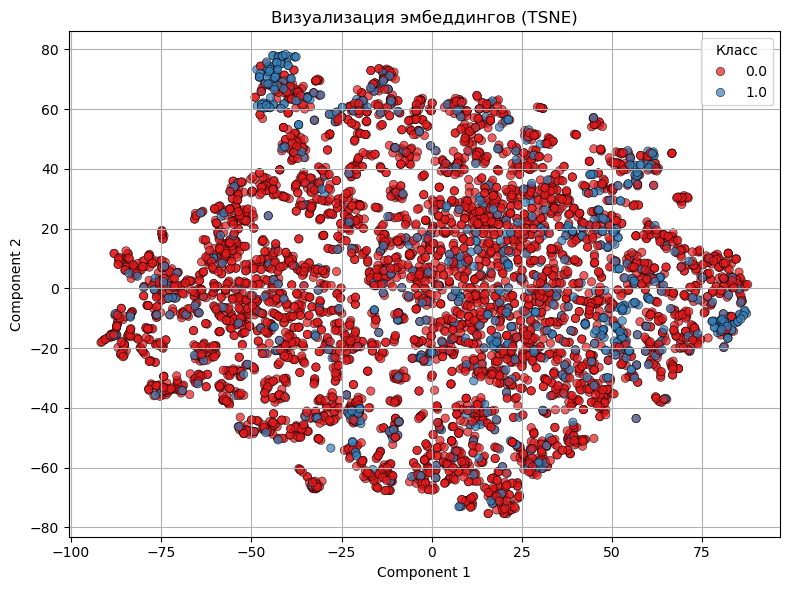

In [67]:
plot_embeddings(df_embedded, method="tsne")

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


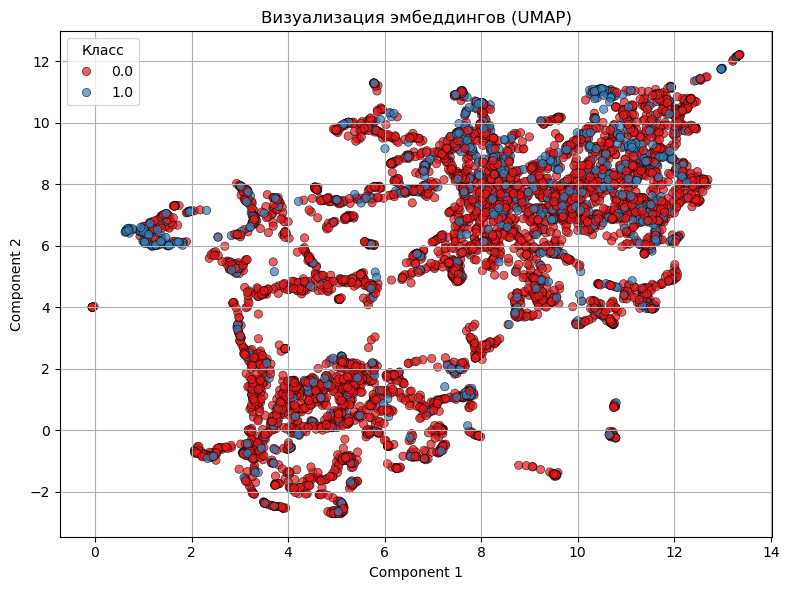

In [68]:
plot_embeddings(df_embedded, method="umap")

### MLP

In [77]:
X_train = df_train_embedded.drop(columns=['toxicity']).values
y_train = df_train_embedded['toxicity'].values

In [79]:
train_idx_random, test_idx_random = train_test_split(X_train, y_train, n_splits=6)

In [83]:
df_train_embedded, df_valid_embedded = form_data(df_train_embedded, train_idx_random, test_idx_random)

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [90]:
class BinaryDataset(Dataset):
    def __init__(self, df, target_col='toxicity'):
        self.X = torch.tensor(df.drop(columns=[target_col]).values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [91]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        layers.append(nn.Linear(dims[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [119]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                n_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Валидация
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        print(f"[{epoch+1}] Train loss: {np.mean(train_losses):.4f}, Val loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model)
    return model

In [120]:
def evaluate(model, loader, device='cuda'):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            y_score.extend(probs.flatten())
            y_pred.extend(preds.flatten())
            y_true.extend(y_batch.numpy().flatten())

    metrics = compute_metrics(y_true, y_pred, y_score)
    return metrics


In [121]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=df_train_embedded['toxicity'])
pos_weight = torch.tensor(class_weights[0] / class_weights[1])

In [122]:
train_dataset = BinaryDataset(df_train_embedded)
valid_dataset = BinaryDataset(df_valid_embedded)
test_dataset = BinaryDataset(df_test_embedded)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [123]:
input_dim = df_train_embedded.drop(columns=['toxicity']).shape[1]
model = MLP(input_dim=input_dim).to(device)

In [124]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [125]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, device=device, n_epochs=100, patience=10)

[1] Train loss: 0.2221, Val loss: 0.1163
[2] Train loss: 0.0968, Val loss: 0.1137
[3] Train loss: 0.0913, Val loss: 0.1083
[4] Train loss: 0.0892, Val loss: 0.1099
[5] Train loss: 0.0872, Val loss: 0.1084
[6] Train loss: 0.0859, Val loss: 0.1100
[7] Train loss: 0.0860, Val loss: 0.1086
[8] Train loss: 0.0844, Val loss: 0.1072
[9] Train loss: 0.0836, Val loss: 0.1063
[10] Train loss: 0.0834, Val loss: 0.1090
[11] Train loss: 0.0818, Val loss: 0.1106
[12] Train loss: 0.0805, Val loss: 0.1061
[13] Train loss: 0.0803, Val loss: 0.1126
[14] Train loss: 0.0800, Val loss: 0.1108
[15] Train loss: 0.0792, Val loss: 0.1057
[16] Train loss: 0.0774, Val loss: 0.1053
[17] Train loss: 0.0773, Val loss: 0.1105
[18] Train loss: 0.0767, Val loss: 0.1061
[19] Train loss: 0.0753, Val loss: 0.1105
[20] Train loss: 0.0730, Val loss: 0.1075
[21] Train loss: 0.0742, Val loss: 0.1169
[22] Train loss: 0.0717, Val loss: 0.1112
[23] Train loss: 0.0711, Val loss: 0.1131
[24] Train loss: 0.0703, Val loss: 0.1180
[

In [127]:
val_metrics = evaluate(model, valid_loader, device)
val_metrics

{'precision': 1.0,
 'recall': 0.01834862385321101,
 'sensitivity': 1.0,
 'f1': 0.036036036036036036,
 'roc_auc': 0.7424951632028958}

In [128]:
test_metrics = evaluate(model, test_loader, device)
test_metrics

{'precision': 1.0,
 'recall': 0.046153846153846156,
 'sensitivity': 1.0,
 'f1': 0.08823529411764706,
 'roc_auc': 0.7402014652014652}